<a href="https://colab.research.google.com/github/seenu-g/school_of_ai/blob/master/chap6/No_L1_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


**Model**

In [0]:
dropout_value = 0.03
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layer1 = nn.Sequential(                      
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=True),#Op_size = 26, RF = 3
            nn.ReLU(),
            nn.BatchNorm2d(num_features=12),
            nn.Dropout2d(dropout_value)
        )
        self.conv_layer2 = nn.Sequential(  
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=True),#Op_size = 24, RF = 5
            nn.ReLU(),
            nn.BatchNorm2d(num_features=12),
            nn.Dropout2d(dropout_value)
        )
        self.maxpool_layer1 = nn.MaxPool2d(kernel_size=(2,2)) #Op_size = 12, RF = 6
        self.conv_layer3 = nn.Sequential(  
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=True), #Op_size = 10, RF = 10   
            nn.ReLU(),
            nn.BatchNorm2d(num_features=14),
            nn.Dropout2d(dropout_value)
        )
        self.conv_layer4 = nn.Sequential(  
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=True), #Op_size = 8, RF = 14
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            nn.Dropout2d(dropout_value) 
        )
        self.conv_layer5 = nn.Sequential(  
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=True),#Op_size = 6, RF = 18 
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            nn.Dropout(dropout_value)
        )
        self.conv_layer6 = nn.Sequential(  
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=True),#Op_size = 6, RF = 22 
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            nn.Dropout(dropout_value)
        )            
        self.avgpool_layer1 = nn.AvgPool2d(kernel_size=6)

        self.conv_layer7 = nn.Sequential(  
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=True)#Op_size = 1, RF = 28
        )

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x =  self.maxpool_layer1(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = self.conv_layer5(x)
        x = self.conv_layer6(x)
        x = self.avgpool_layer1(x)
        x = self.conv_layer7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

*italicized text*# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1,28,28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
         Dropout2d-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,308
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
         Dropout2d-8           [-1, 12, 24, 24]               0
         MaxPool2d-9           [-1, 12, 12, 12]               0
           Conv2d-10           [-1, 14, 10, 10]           1,526
             ReLU-11           [-1, 14, 10, 10]               0
      BatchNorm2d-12           [-1, 14, 10, 10]              28
        Dropout2d-13           [-1, 14, 10, 10]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Epoch={epoch} Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [8]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Epoch=0 Loss=0.04288334771990776 Batch_id=468 Accuracy=88.55: 100%|██████████| 469/469 [00:11<00:00, 40.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0677, Accuracy: 9841/10000 (98.41%)

EPOCH: 1


Epoch=1 Loss=0.030717911198735237 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:11<00:00, 47.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 9866/10000 (98.66%)

EPOCH: 2


Epoch=2 Loss=0.02718837559223175 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:11<00:00, 41.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9907/10000 (99.07%)

EPOCH: 3


Epoch=3 Loss=0.05158885940909386 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:11<00:00, 41.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9910/10000 (99.10%)

EPOCH: 4


Epoch=4 Loss=0.0424419641494751 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:11<00:00, 40.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9924/10000 (99.24%)

EPOCH: 5


Epoch=5 Loss=0.02606876753270626 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:11<00:00, 41.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9910/10000 (99.10%)

EPOCH: 6


Epoch=6 Loss=0.023678133264183998 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:11<00:00, 41.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Epoch=7 Loss=0.014487043023109436 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:11<00:00, 39.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9931/10000 (99.31%)

EPOCH: 8


Epoch=8 Loss=0.07461904734373093 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:11<00:00, 40.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9920/10000 (99.20%)

EPOCH: 9


Epoch=9 Loss=0.0264386385679245 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:11<00:00, 40.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Epoch=10 Loss=0.05499504879117012 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:11<00:00, 40.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Epoch=11 Loss=0.0049154809676110744 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:11<00:00, 47.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9921/10000 (99.21%)

EPOCH: 12


Epoch=12 Loss=0.08977577835321426 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:11<00:00, 41.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Epoch=13 Loss=0.006126895546913147 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:11<00:00, 40.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Epoch=14 Loss=0.010122229345142841 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:11<00:00, 40.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9936/10000 (99.36%)

EPOCH: 15


Epoch=15 Loss=0.001938149333000183 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:11<00:00, 40.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9930/10000 (99.30%)

EPOCH: 16


Epoch=16 Loss=0.02140083909034729 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:11<00:00, 40.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Epoch=17 Loss=0.016483664512634277 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:11<00:00, 40.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9940/10000 (99.40%)

EPOCH: 18


Epoch=18 Loss=0.010254775173962116 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:11<00:00, 40.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9922/10000 (99.22%)

EPOCH: 19


Epoch=19 Loss=0.004034683108329773 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:11<00:00, 41.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9932/10000 (99.32%)

EPOCH: 20


Epoch=20 Loss=0.04348228499293327 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:11<00:00, 41.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9930/10000 (99.30%)

EPOCH: 21


Epoch=21 Loss=0.03229488804936409 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:11<00:00, 40.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9937/10000 (99.37%)

EPOCH: 22


Epoch=22 Loss=0.006243626121431589 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:11<00:00, 41.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9933/10000 (99.33%)

EPOCH: 23


Epoch=23 Loss=0.05646447837352753 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:11<00:00, 39.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9937/10000 (99.37%)

EPOCH: 24


Epoch=24 Loss=0.002958630444481969 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:11<00:00, 41.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9940/10000 (99.40%)

EPOCH: 25


Epoch=25 Loss=0.04282763972878456 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:11<00:00, 41.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9937/10000 (99.37%)

EPOCH: 26


Epoch=26 Loss=0.04500891640782356 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:11<00:00, 41.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9932/10000 (99.32%)

EPOCH: 27


Epoch=27 Loss=0.012997959740459919 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:11<00:00, 41.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9938/10000 (99.38%)

EPOCH: 28


Epoch=28 Loss=0.003670151112601161 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:11<00:00, 40.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9926/10000 (99.26%)

EPOCH: 29


Epoch=29 Loss=0.011418362148106098 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:11<00:00, 40.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99.37%)

EPOCH: 30


Epoch=30 Loss=0.0074320584535598755 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:11<00:00, 40.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9941/10000 (99.41%)

EPOCH: 31


Epoch=31 Loss=0.00263427197933197 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:11<00:00, 41.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9937/10000 (99.37%)

EPOCH: 32


Epoch=32 Loss=0.0033887922763824463 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:11<00:00, 40.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9936/10000 (99.36%)

EPOCH: 33


Epoch=33 Loss=0.002049679635092616 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:11<00:00, 41.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9943/10000 (99.43%)

EPOCH: 34


Epoch=34 Loss=0.0011396706104278564 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:11<00:00, 41.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9941/10000 (99.41%)

EPOCH: 35


Epoch=35 Loss=0.00685014808550477 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:11<00:00, 39.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9939/10000 (99.39%)

EPOCH: 36


Epoch=36 Loss=0.0034667353611439466 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:11<00:00, 41.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9946/10000 (99.46%)

EPOCH: 37


Epoch=37 Loss=0.009924580343067646 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:11<00:00, 40.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9938/10000 (99.38%)

EPOCH: 38


Epoch=38 Loss=0.002546663163229823 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:11<00:00, 40.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9937/10000 (99.37%)

EPOCH: 39


Epoch=39 Loss=0.012657691724598408 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:11<00:00, 40.42it/s]



Test set: Average loss: 0.0176, Accuracy: 9943/10000 (99.43%)



Text(0.5, 1.0, 'Test Accuracy')

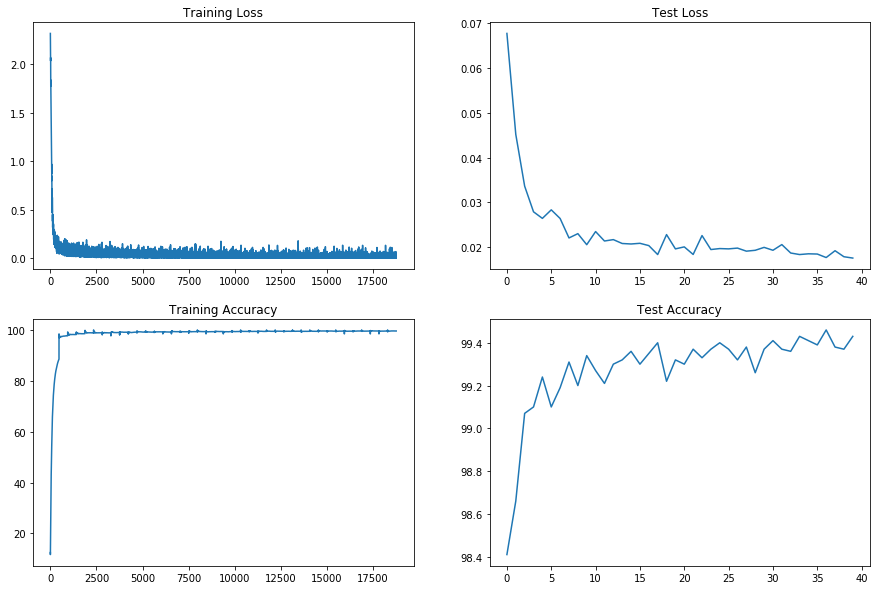

In [9]:

import numpy as np
from matplotlib import pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")